In [1]:
import pandas as pd #module to work with dataframes
import networkx as nx #module to work with networks
import numpy as np
import scipy as scpy
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite #we load the bipartite algorithms to facilitate writing the code
import random
from Functions import *
#%matplotlib inline

# Network Structure I: Centrality metrics (node-escale)

## Paths 

A *path* in a network is a sequence of edges connecting two nodes. Let's start with a very simple, undirected network.

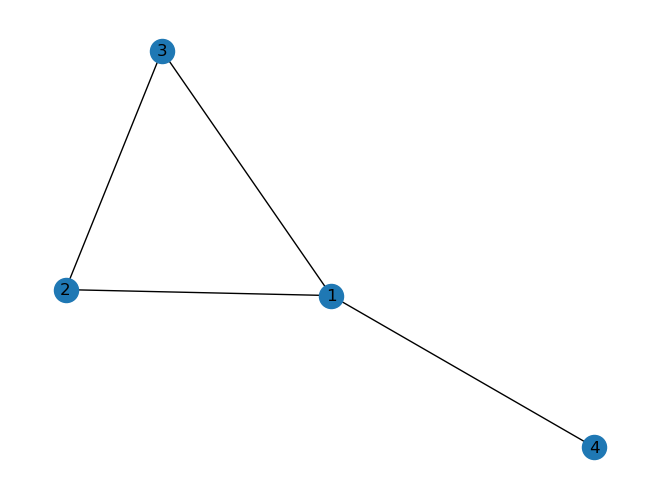

In [2]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4])
G.add_edges_from([(1,2),(2,3),(1,3),(1,4)])
nx.draw(G, with_labels=True)

In this simple example, we can easily see that there is indeed at least one path that connects nodes 3 and 4. We can verify this with the NetworkX function `nx.has_path(G, start node, end node)`

In [3]:
nx.has_path(G, 3, 4)

True

There can be more than one path between two nodes. Again considering nodes 3 and 4, there are two such "simple" paths:

In [4]:
list(nx.all_simple_paths(G, 3, 4))

[[3, 2, 1, 4], [3, 1, 4]]

We are often most interested in **shortest paths**. In an unweighted network, the shortest path is the one with the fewest edges. We can see that of the two simple paths between nodes 3 and 4, one is shorter than the other. We can get this shortest path with a single NetworkX function `nx.shortest_path(G, start node, end node)`

In [5]:
nx.shortest_path(G, 3, 4)

[3, 1, 4]

If you only care about the path length, there's a function for that too: `nx.shortest_path_length(G, start node, end node)`

In [6]:
nx.shortest_path_length(G, 3, 4)

2

> Note that a path length is defined here by the number of *edges* in the path, not the number of nodes, which implies that for nodes $u$ and $v$.
>
>    `nx.shortest_path_length(G, u, v) == len(nx.shortest_path(G, u, v)) - 1`
   

You can also obtain the average shortest path length between any pair of nodes in the network with `nx.average_shortest_path_length(G)`, and the maximum shortest path length (or network diameter) with `nx.diameter(G)`

In [7]:
nx.average_shortest_path_length(G)

1.3333333333333333

In [8]:
nx.diameter(G)

2

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h4> Exercise 9</h4>
Let's work with the network of US air travel routes. The nodes in this graph are airports, represented by their IATA codes.

![title](./images/figure6.png)
    
Two nodes are connected with an edge if there is a scheduled flight directly connecting these two airports. We'll assume this graph to be undirected since a flight in one direction usually means there is a return flight.
Thus this graph has edges

[('HOM', 'ANC'), ('BGM', 'PHL'), ('BGM', 'IAD'), ...]

where ANC is Anchorage, IAD is Washington Dulles, etc.
    
Load the network of USA flights and analyze it to answer these questions:
    
- 1) Is there a direct flight between Indianapolis (IND) and Fairbanks, Alaska (FAI)? A direct flight is one with no intermediate stops.
- 2) If I wanted to fly from Indianapolis to Fairbanks, Alaska what would be an itinerary with the fewest number of flights?
- 3) Can you name these airpotrs (hint: access the "name" attribute of the airport node and print it)

</div>

In [9]:
#write your code here. The network is already loaded
G = nx.read_graphml('./data/openflights_usa.graphml.gz')
#G.nodes(data=True)

In [10]:
# %load ./snippets/ex9.py

Let's extend these ideas about paths to directed graphs.
### Directed paths

We know that in a directed graph, an edge from an arbitrary node $u$ to an arbitrary node $v$ does not imply that an edge exists from $v$ to $u$. Since paths must follow edge direction in directed graphs, the same asymmetry applies for paths. Observe that this graph has a path from 1 to 4, but not in the reverse direction.

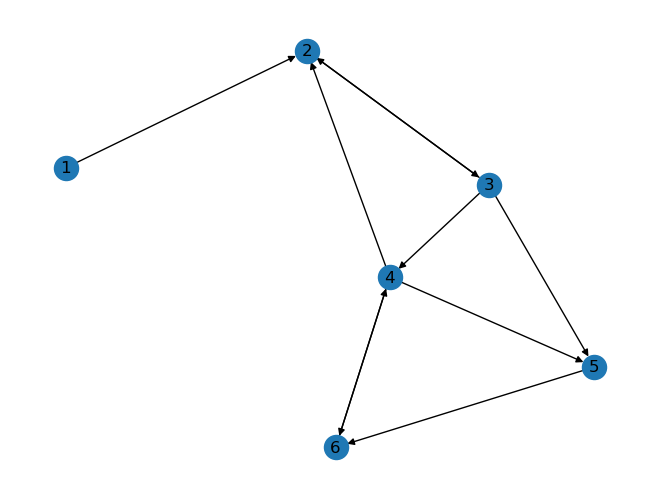

In [11]:
D = nx.DiGraph()
D.add_edges_from([
    (1,2),
    (2,3),
    (3,2), (3,4), (3,5),
    (4,2), (4,5), (4,6),
    (5,6),
    (6,4),
])
nx.draw(D, with_labels=True)

In [12]:
nx.has_path(D, 1, 4)

True

In [13]:
nx.has_path(D, 4, 1)

False

The other NetworkX functions dealing with paths take this asymmetry into account as well:

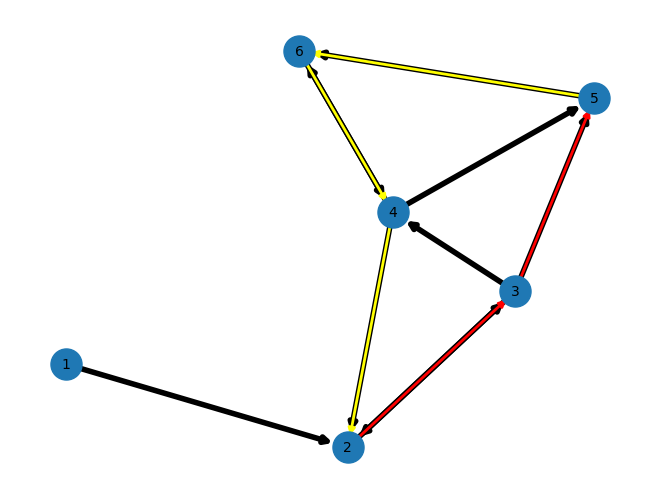

In [14]:
shortest_path1=nx.shortest_path(D, 2, 5)
shortest_path2=nx.shortest_path(D, 5, 2)

#lets represent the colroed path. First obtein edges
path1_edges = list(zip(shortest_path1, shortest_path1[1:])) 
path2_edges = list(zip(shortest_path2, shortest_path2[1:])) 

#plot the graph and the edges on top
pos = nx.spring_layout(D)  # Positions for all nodes
nx.draw(D, pos, with_labels=True, node_size=500, font_size=10,width=4)
nx.draw_networkx_edges(D, pos, edgelist=path1_edges, edge_color='red', width=2) #this needs the position of nodes as an input!! 
nx.draw_networkx_edges(D, pos, edgelist=path2_edges, edge_color='yellow', width=2) #this needs the position of nodes as an input!! 
plt.show()

> Note: Since there is no edge from 5 to 3, the shortest path from 5 to 2 cannot simply backtrack the shortest path from 2 to 5 -- it has to go a longer route through nodes 6 and 4.

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h4> Exercise 10</h4>
Imagine that after an accident, the 'Suspension-feeding molluscs' have been contaminated with lead. Taking into cosideration the structure of the trophic interactions in the St Marks estudary, aswer the following questions:
    
- 1 Should we be worried about the well fare of the 'Tonguefish'? 
- 2 and what about the 'Fish and crustacean-eating birds'?
- 3 Should we expect more accumulation of lead in 'Herbivorous ducks' or in 'Fish and crustacean-eating birds', according to their diets? (hint: only consider length of trophic chain)
    
![title](./images/figure10.jpg)
</div>

In [15]:
# Start by loading the network as we did before, and continue with your code
filename="./data/WoL_StMarks/st_marks_Ilist.csv"
Ilist=pd.read_csv(filename, header=None, index_col=None)
Ilist.columns=["source","target","w"]
FW=nx.from_pandas_edgelist(Ilist, edge_attr="w", create_using=nx.DiGraph)
species=list(FW.nodes())
sp0='Suspension-feeding molluscs' 

In [16]:
# %load ./snippets/ex10.py


> If the netowrk is **weighted** (regardless of it being directed or undirected) the shortest path function uses the Dijkstra’s Shortest Path Algorithm automatically, taking the weights into consideration

## Centrality metrics I

Often when looking at a network, we want to find the most "important" nodes, for some definition of important. The most basic measure of centrality is the *degree*, or number of links attached to a node. Let's take a look at the network we have loaded.

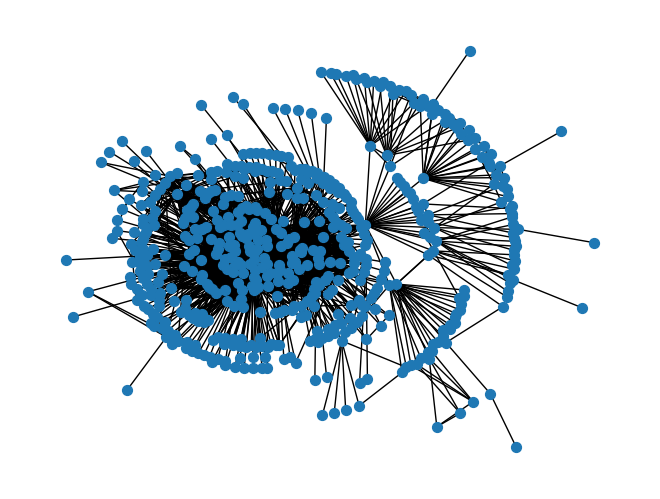

In [17]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos,node_size=50)

### Degree centraility

Do all airports seem equally easy to access? The degree centrality tell us the **number of neighbours of each node**. In this case, it can be understood as a proxy of how well connected is a given airport. As we saw in lesson 1, we can obtain the **degree centrality** of the nodes in the network using the method `G.degree(node)`.
Usually the degree of node $i$ is represented with by $k_i$. We will say that a node has a higher degree centrality if it has a higher degree (i.e. if it has many neighbours). The rationale is **the more connections** a node has -> **the more important** hte node is

In [18]:
K=pd.Series(dict(G.degree())).sort_values(ascending=False) #let's store the degrees of the nodes in a series, so we can easily access later
print(K.head(5))

ATL    153
ORD    149
DEN    148
DFW    138
MSP    117
dtype: int64


We can now find which is the best connected airport in the US

In [19]:
airport=K.idxmax()
print("The most connected airport is the %s with %s direct flights to other destinations" % (G.nodes[airport]["name"],K[airport]))

The most connected airport is the Hartsfield Jackson Atlanta International Airport with 153 direct flights to other destinations


#### Degree distributions
What is the bigger difference between these two networks?

![title](./images/figure7.png)

The most basic structural properties of a network are the number of nodes (**N**) and the number of links (**L**). However, how these links are distributed among the nodes (**$K_i$**) has deep implications for other network properties (it is not the same to have all nodes with similar degree, or having a very heterogeneous dostribution). The degree distribution will play a very important role determining other structural metrics in the networks.
We can see the **degree distribution** of a network by doing a histogram of the degree series. This will tell us how many nodes with a given number of neighbours are in the network.


In [20]:
#do histogram of degree. Fixed bin width to 1.
bins = np.arange(K.min(), K.max() + 2, 1)#fix width of bin to 1
hist, bin_edges = np.histogram(K, bins=bins)

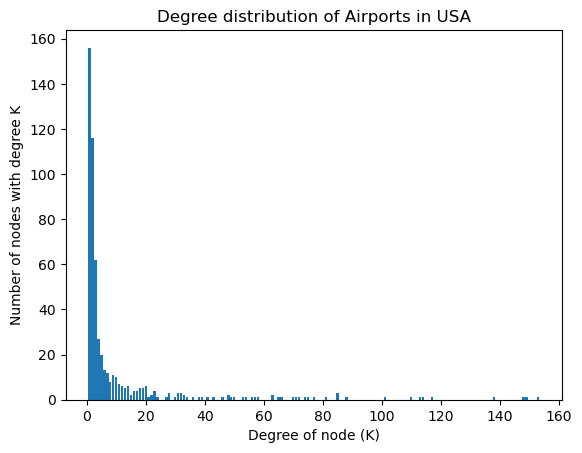

In [21]:
#let's plot the histogram to see ho is K distributed
plt.bar(bin_edges[:-1],hist)
#plt.plot(bin_edges[:-1], hist, 'o',color="k",alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')
plt.title("Degree distribution of Airports in USA")
plt.xlabel("Degree of node (K)")
plt.ylabel("Number of nodes with degree K")
plt.show()

And we can also obtain simple statistics from it, like the mean degree, and its standard deviation

In [22]:
K_mean=K.mean()
K_std=K.std()

print("The average number of direct flights from an US airport is %.2f +- %.2f"  % (K_mean,K_std))

The average number of direct flights from an US airport is 10.19 +- 21.26


> Note: In these **long tailed distributions** the verage value is not representative of anything, as the standard distribution is larger than the mean!!

There has been a lot of debate regarding the form of the degree distribution ($P(K)$) in real networks. The best practice to determine which function fits better the $P(K)$) is to use the **cumulative degree distribution** (i.e. how many nodes with degree $K$ or below are in the network) because it is less noisi. 
Let's see how we can do this.

Let's compare the degree distribution of the empirical network with a random one:

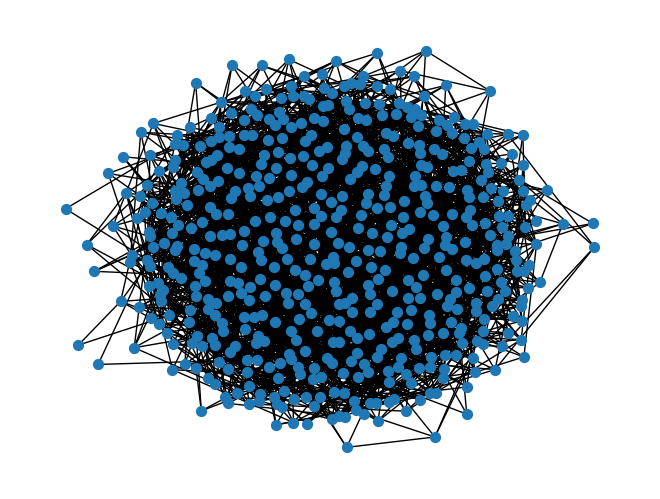

In [23]:
#compare with a random network:
#obtain N, L and genetare random network
N=G.number_of_nodes()
L=G.number_of_edges()
Grnd=nx.gnm_random_graph(N,L,directed=False)

posr = nx.kamada_kawai_layout(Grnd)
nx.draw(Grnd,posr,node_size=50)

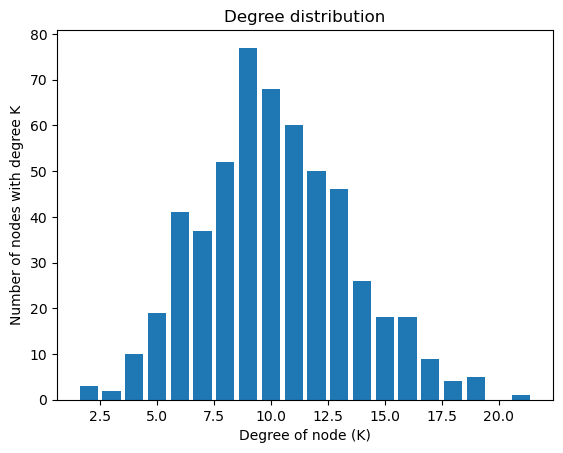

In [24]:
#get degree of nodes in the network
Krnd=pd.Series(dict(Grnd.degree())).sort_values(ascending=False) 
#do histogram of degree. Fixed bin width to 1.
binsr = np.arange(Krnd.min(), Krnd.max() + 2, 1)#fix width of bin to 1
histr, bin_edgesr = np.histogram(Krnd, bins=binsr)
#let's plot the histogram to see ho is K distributed
plt.bar(bin_edgesr[:-1],histr)
plt.title("Degree distribution")
plt.xlabel("Degree of node (K)")
plt.ylabel("Number of nodes with degree K")
plt.show()

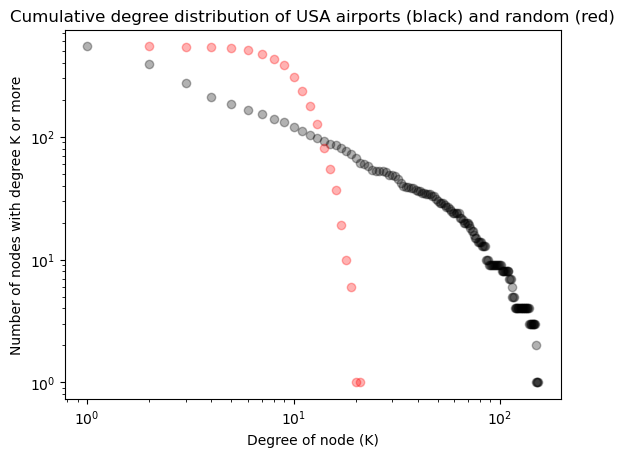

In [25]:
#Compute the cumulative sum, but in reverse order to count values greater than or equal
cumulative_hist = np.cumsum(hist[::-1])[::-1]
cumulative_histr = np.cumsum(histr[::-1])[::-1]
#plot
plt.plot(bin_edges[:-1], cumulative_hist, 'o',color="k",alpha=0.3)
plt.plot(bin_edgesr[:-1], cumulative_histr, 'o',color="r",alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title("Cumulative degree distribution of USA airports (black) and random (red)")
plt.xlabel("Degree of node (K)")
plt.ylabel("Number of nodes with degree K or more") #
plt.show()

#### Generalizing "neighbors" to arbitrarily-sized graphs

The concept of neighbors is simple and appealing,
but it leaves us with a slight point of dissatisfaction:
it is difficult to compare graphs of different sizes.
Is a node more important solely because it has more neighbors?
What if it were situated in an extremely large graph?
Would we not expect it to have more neighbors?

As such, we need a normalization factor.
One reasonable one, in fact, is
_the number of nodes that a given node could **possibly** be connected to._
By taking the ratio of the number of neighbors a node has
to the number of neighbors it could possibly have,
we get the **degree centrality** metric.

Formally defined, the degree centrality of a node (let's call it $d$)
is the number of neighbors that a node has (let's call it $k$, its degree)
divided by the number of neighbors it could _possibly_ have (let's call it $N$, all nodes):

$$d = \frac{k}{N}$$

NetworkX provides a function for us to calculate **degree centrality** conveniently:

ATL    0.280734
ORD    0.273394
DEN    0.271560
DFW    0.253211
MSP    0.214679
dtype: float64


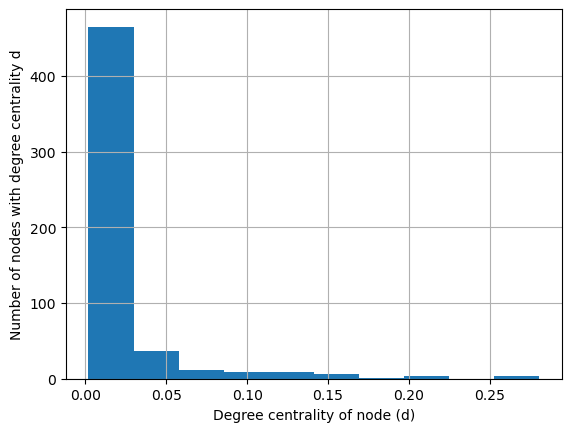

In [26]:
d = pd.Series(nx.degree_centrality(G)).sort_values(ascending=False)
print(d.head())
d.hist()
plt.xlabel("Degree centrality of node (d)")
plt.ylabel("Number of nodes with degree centrality d")
plt.show()

> Note: degree centrality is usefull to determine how "central" a node is **across** different networks, since **it does not make sense to compare the raw number of neighbours across networks with different size**!!

### Degree centraility in bipartite networks
When we are working with bipartite networks, we should use the algorithms included in `nx.bipartite` and not those of the unipartite networks! 

Lets see some examples
In the bipartite case, the maximum possible degree of a node in a bipartite node set is the number of nodes in the opposite node set. The degree centrality for a node $u$ in the bipartite set $U$ with $n$ nodes that is connected to nodes in the bipartite set $V$ with $m$ nodes is
$$d_u=\frac{k_u}{m}$$, for $u\in U$, and for a node $v$ nodes in set $V$ is $$d_v=\frac{k_v}{n}$$, for $v\in V$,

where $k_v$ is the degree of node v.

In [27]:
#load the crime network
Bcrime = load_crime_network()
person_nodes = {n for n, d in Bcrime.nodes(data=True) if d["bipartite"] == 'person'}
crime_nodes = set(Bcrime) - person_nodes


In [28]:
DC=pd.Series(dict(nx.degree_centrality(Bcrime))).sort_values(ascending=False) #using the unipartite function not paying attention to the bipartite sets
DC.head()

p815    0.018129
p2      0.015954
c110    0.013053
p425    0.013053
p220    0.012328
dtype: float64

In [29]:
DC_bipart=pd.Series(dict(bipartite.degree_centrality(Bcrime,person_nodes))).sort_values(ascending=False)#using the bipartite function!!
DC_bipart.head()

p815    0.045372
p2      0.039927
p425    0.032668
p220    0.030853
p56     0.025408
dtype: float64

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h3> Exercise 11</h3>
Load the  two seed-dispersal networks of and answer the following questions:

- 1. What is the **degree** of the bird named 'Loxigilla portoricensis ' in the two networks? (the space in the name is not an error)
- 2. What is its **degree centrality** in the two networks?
- 3. In which network is more "central"?
- 4. Obtain the degree distribution of the animals in the network


</div>

In [30]:
#hints:
#load first network
a0='Loxigilla portoricensis '
filename="./data/WoL_fugivory/1.csv" 
Idf1=pd.read_csv(filename, header=0, index_col=0)
B1 = nx.Graph()
# Add producers (rows) and consumers (columns) as nodes
plants1 = Idf1.index
animals1 = Idf1.columns
B1.add_nodes_from(plants1, bipartite="plant")  # Set for producers
B1.add_nodes_from(animals1, bipartite="animal")  # Set for consumers
    # Add edges for non-zero interactions, we can also use the matrix directly
for plant in plants1:
    for animal in animals1:
        if Idf1.loc[plant, animal] != 0:
            B1.add_edge(plant, animal)
#continue your code below
# - load the second network
# - get the degree of the bird in each network
# - calculate the degree centrality of the nodes as we just saw and get that of the animal with D1.loc[a0] (this selects the element a0 from the series D1)
# - Obtain the series of degree of each node, build the cumulative histogram for each network and plot it

In [31]:
# %load ./snippets/ex11.py


### Betweenness centrality
We just saw how a node that is "important" could be so because it is connected to many other nodes. The rationale is that it exersts a lot of **direcet** influence on their neighbours.

Paths give us an alternative definition. If we imagine that we have to pass a message on a graph from one node to another,
then there may be "bottleneck" nodes for which if they are removed,then messages have a harder time flowing through the graph.

One metric that measures this form of importance is the **betweenness centrality** metric.
On a graph through which a generic "message" is flowing, a node with a high betweenness centrality
is one that has a high proportion of shortest paths flowing through it.
In other words, it behaves like a _bottleneck_.
In some cases you can be more interested in knowing the extent to which a node lies on paths between other nodes. For example, the airport that is most used as an intermediate stop between other destinations. 

NetworkX provides a `.betweenness centrality` function that behaves consistently with the `.degree centrality` function, in that it returns a mapping from node to metric.
To claculate the betweeness centrality we do:

In [32]:
betweenness = pd.Series(nx.centrality.betweenness_centrality(G)).sort_values(ascending=False)

In [33]:
print(betweenness) # the betwennes centrality of airports

ANC    0.318991
DEN    0.150853
ORD    0.126094
SEA    0.122088
ATL    0.088898
         ...   
ENA    0.000000
BKW    0.000000
TEB    0.000000
MQT    0.000000
NUI    0.000000
Length: 546, dtype: float64


### Closeness centrality

Also based in te idea of traveling trough the graph, Closeness centrality indicates how close a node is to all other nodes in the network. It is calculated as the average of the shortest path length from the node to every other node in the network. In the airport network it means the airport that is best connected to the rest of the airports (in fewer jumps).

> Beware, as it can be infinite if there are not connected nodes!

In [34]:
closenness = pd.Series(nx.centrality.closeness_centrality(G)).sort_values(ascending=False)
print(closenness)

DEN    0.503880
ORD    0.501975
MSP    0.487238
LAS    0.487238
SEA    0.478891
         ...   
FRD    0.004128
DUT    0.003670
CLM    0.003303
KQA    0.002446
AKB    0.002446
Length: 546, dtype: float64


You probably realized that the centrality metrics of nodes do **NOT** neccesarily coincide, that is, one can have many direct lfights to other destinations, but not be an airport where people change flights, or not be very close to all other airports. Let's see it in our Airports network:

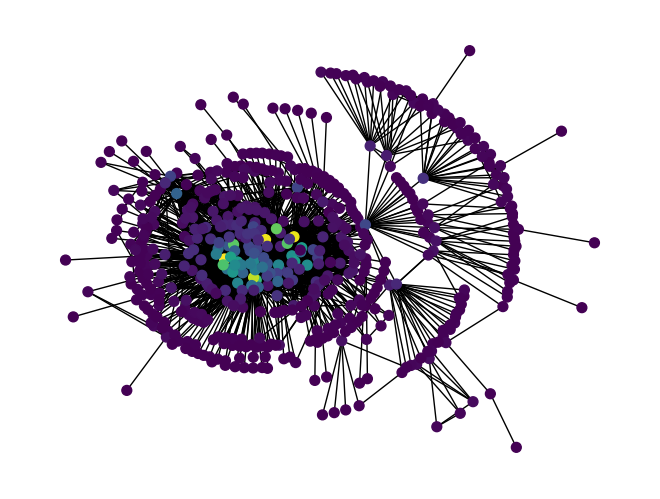

In [35]:
Airports=list(G.nodes) # Colored by degree
nx.draw(G,pos,node_color=d[Airports],node_size=50)

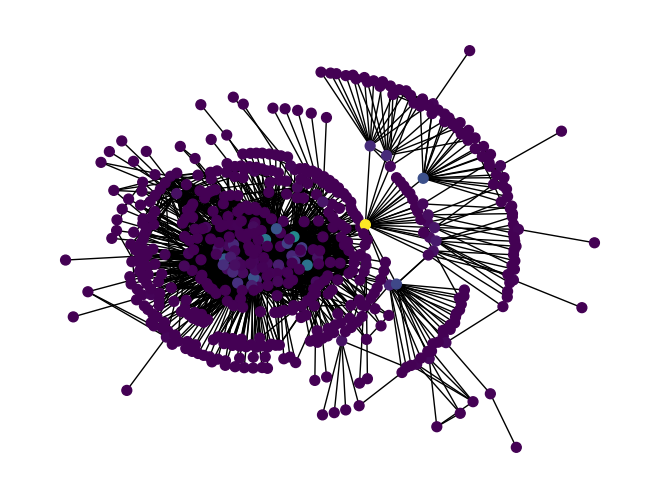

In [36]:
nx.draw(G,pos,node_color=betweenness[Airports],node_size=50) # colored by betwenness

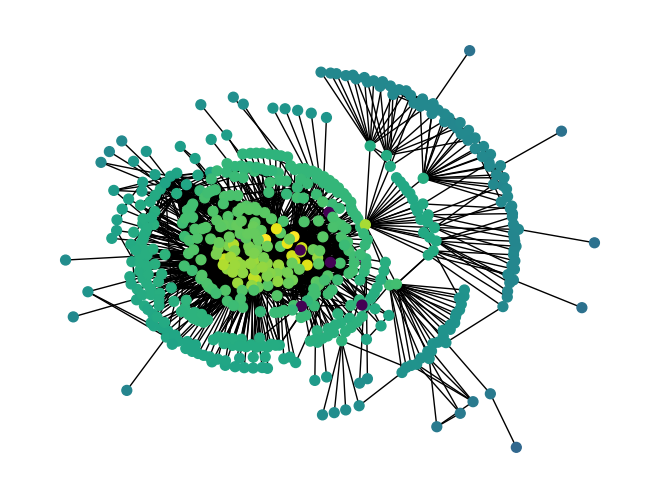

In [37]:
nx.draw(G,pos,node_color=closenness[Airports],node_size=50)#colored by closeness

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h3> Exercise 12</h3>
Now that we have seen the differnt ways in what nodes can be central, work with the airport network and answer these questions:
    
- 1. What is the airport with more direct flights?
- 2.  Imagine you are a CEO of an USA corporation and take frequent flights to many different places across the states. In what city do you ask the company to rent you a flat? 
- 3.  Your corporation (that aims expand as restaurants in airports) ask you the airport where they should put the first restaurant (hint: you don't have access to the actual number of people travelling, only to the airports network)
</div>

In [38]:
#write your code here

In [39]:
# %load ./snippets/ex12.py


## Consecuences of the structure (testing Robustness)

Another way to think about the relative "importance" of nodes in a network is to measure how much it would damage the network structure if particular nodes were to be removed. In real life, node removal might be a person moving away and out of a social network, someone changing jobs and being removed from an email network, internet routers being attacked/overloaded and going down, etc.

Broadly, we consider two types of network damage: **random failure** and **targeted attack**. In a random failure, nodes are chosen randomly for removal. In a targeted attack, we will remove nodes based on some criterion, for example, removing nodes in decreasing order of their degree centrality.

### Random failure

Whenever we're going to engage in a distructive process, we want to make a copy of the network graph to attack so that we can easily get back to the original state:

In [40]:
C = G.copy()

To simulate random failure, we randomly choose some node names and remove them from the graph. We can use `random.sample` to remove more than one node at at time. Note that we need to make a `list` of node names from which to randomly sample:

In [41]:
nodes_to_remove = random.sample(list(C.nodes), 5) #lets attack 5 airports at a time
print(nodes_to_remove)

['TOL', 'ATY', 'EVV', 'KLW', 'LEB']


You can remove nodes from the network with

In [42]:
print(C.number_of_nodes())
C.remove_nodes_from(nodes_to_remove)
print(C.number_of_nodes())

546
541


The full simulation is going to work like this, beginning from a fresh copy of the network:

1. Measure size of the network core (number of nodes in the largest component) as compared to the original network size
2. Select 5 nodes at random and remove them
3. Repeat until there are less than 5 nodes

We can then use `range` to generate a sequence of the total number of nodes removed at each step:

In [43]:
M=1 #this was is easier to change this value later
num_nodes_removed = range(0, G.number_of_nodes(), M) # we will remove nodes 5 at a time
num_nodes_removed

range(0, 546)

Generate a random ordering of the nodes, that we will attack 5 at a time

In [44]:
nodes = list(G.nodes())
random_node_ordering=random.sample(nodes, len(nodes))

The loop is fairly simple. At each step, we need to record the fraction of remaining nodes in the core.

In [45]:
N = G.number_of_nodes()
C = G.copy()
random_attack_core_proportions = []
i=0
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = max(nx.connected_components(C), key=len) # we will see more about this later, for now consider is a measure of the integrity of the network
    core_proportion = len(core) / N
    random_attack_core_proportions.append(core_proportion) # we are creating a list with the proportion of nodes in the largest component

    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random_node_ordering[i:i+M]
        C.remove_nodes_from(nodes_to_remove)
        i += M

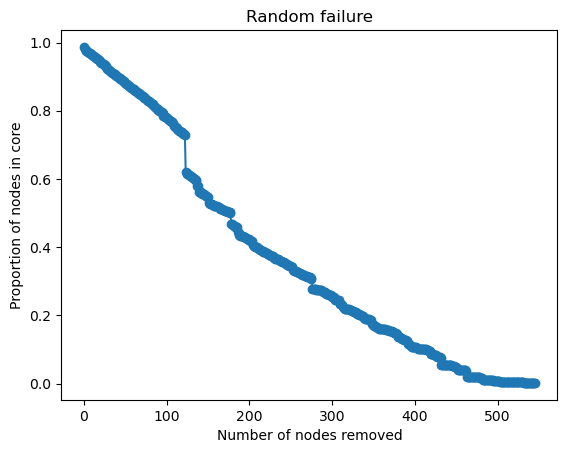

In [46]:
plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o') #we plot the proportion of nodes in the giant component vs the number of removed nodes
plt.show()

#### Targeted attack

Simulating a targeted attack is similar, except that instead of choosing randomly, we will select the M most central nodes (according to differentcentrality metrics) at each step. To accomplish this we want something like the `max` function used earler to get the most central node, but able to get the top M nodes. We can use Python's `sorted` function in a similar way to `max` to first sort the nodes by centrality in descending, or reverse, order. Once sorted by degree, we take the first M nodes in the list:

<div class="alert alert-block alert-success"><b>Up to you: </b>
<h3> Exercise 13 </h3>
Now try differnt orderings when attacking the airports. If you wanted to isolate the country as fast as possible which technique would you use?
</div>

NameError: name 'B_attack_core_proportions' is not defined

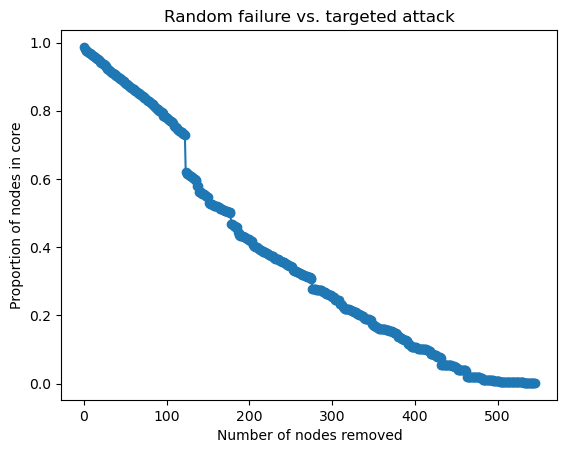

In [47]:
# hint: Reuse the  loop from the random attack, but instead of using a list of nodes in random order, use a list of nodes ordered by some property
# 1-copy the loop
# 2-substitute the "random_node_ordering" list by a list of nodes orderd by a centrality metric store them 
# in a series like we did before: closenness = pd.Series(nx.centrality.closeness_centrality(G)).sort_values(ascending=False), and retreve the index with 
# Clos=list(closeness.index)
# 3-To obtain the list of nodes sorted by a given centrality metric
# 4-Instead of storing the results in the list "random_attack_core_proportions" create a new one "target_attack_core_proportions_METRIC" = [] and append the results there
# 5-Compare the different attack methods by plotting all the proportion of remaining nodes in the same graph like this

plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures')
plt.plot(num_nodes_removed, B_attack_core_proportions, marker='^', label='B Attacks')
#.... (you can test all the metrics you want, but dont forget to run a loop, and store the values in a different attack)
plt.legend()
#your code here

In [ ]:
# %load ./snippets/ex13.py

## Other centrality metrics

### K_core decomposition
The k-core of a graph is a maximal subgraph in which every vertex has at least degree kk.
It’s a way to iteratively remove nodes with degree less than kk, resulting in progressively smaller subgraphs.
k-core decomposition identifies these subgraphs for varying values of kk. The larger the kk, the more "central" or "core" the remaining nodes are considered to be in the graph's structure.

For example, a 2-core would be a subgraph where all nodes have at least degree 2, meaning each node is connected to at least two other nodes.
The process continues by removing nodes with degrees less than kk until the condition is met.

In [ ]:
K10=nx.k_core(G,k=10)
nx.draw(K10,node_color=d[list(K10.nodes)],node_size=50)#colored by closeness

you can retrieve the k-core of each node with the function `nx.core_number(G)`

In [ ]:
Kcore=pd.Series(dict(nx.core_number(G)))
Kcore.head()

### Page Rank

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.
However, it can also be used to identify the species that "move" more biomass trough a network, or in general, the node that is most used when trasnporting information trough the graph. Since this is only interesting in **directed graphs** let's use one of our directed networks. It has been used, for example, to find what are the nodes that are pointing to the more "important" nodes, in order to find the species that can cause more harm when they disapear from the network.

In [43]:
# Start by loading the network as we did before
filename="./data/WoL_StMarks/st_marks_Ilist.csv"
Ilist=pd.read_csv(filename, header=None, index_col=None)
Ilist.columns=["source","target","w"]
FW=nx.from_pandas_edgelist(Ilist, edge_attr="w", create_using=nx.DiGraph)
TL=nx.centrality.trophic_levels(FW)#get trophic level of node

In [44]:
TL

{'Benthic algae': 1,
 'Detritus': 1,
 'Halodule': 1,
 'Macro-epiphytes': 1,
 'Micro-epiphytes': 1,
 'Phytoplankton': 1,
 'Atlantic silverside and bay anchovies': 3.6849678497942384,
 'Fish and crustacean-eating birds': 4.402874646007523,
 'Gulls': 4.337055391402389,
 'Bacterioplankton': 2.0,
 'Microprotozoa': 2.6666666666666665,
 'Suspension-feeding molluscs': 2.888888888888889,
 'Zooplankton': 2.888888888888889,
 'Brittle stars': 2.9166666666666665,
 'Deposit-feeding gastropods': 2.9166666666666665,
 'Deposit-feeding peracaridan crustaceans': 2.6666666666666665,
 'Deposit-feeding polychaetes': 2.9166666666666665,
 'Epiphyte-grazing amphipods': 2.0,
 'Hermit crabs': 2.7291666666666665,
 'Microfauna': 2.6666666666666665,
 'Pinfish': 3.414506172839506,
 'Pipefish and seahorses': 3.5120266203703707,
 'Sheepshead minnow': 2.9246031746031744,
 'Spider crabs': 2.0,
 'Spot': 3.6738567386831273,
 'Suspension-feeding polychaetes': 2.9444444444444446,
 'Benthic bacteria': 2.0,
 'Meiofauna': 2.91

Now let's compute the Page rank:

In [ ]:
PR = pd.Series(nx.pagerank(FW.reverse(), alpha=0.9)) #alpha is damping parameter for PageRank, default=0.85.
#PR.head()

In [ ]:
#FW.remove_node(base_node)
species=list(FW.nodes)
pos= nx.shell_layout(FW)
TL=nx.centrality.trophic_levels(FW)
# Modify the y-coordinate based on the trophic level
for node in pos:
    pos[node] = (pos[node][0], TL[node])  # Set the y-position as the trophic level

nx.draw(FW, pos, node_color=PR[species], with_labels=True)
plt.show()